### Урок3. Связь бизнес-показателей и DS-метрик

#### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

In [33]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import itertools
import matplotlib.pyplot as plt


In [57]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [58]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [59]:
X_train.shape, y_train.shape

((52500, 12), (52500,))

In [60]:
X_test.shape, y_test.shape

((17500, 12), (17500,))

In [61]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [63]:
b=1

In [64]:
classifier_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 0.1,random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_lr, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)
y_score_lr = classifier_lr.predict_proba(X_test)[:, 1]

CV score is 0.7844374123135694+-0.005286474572634387


In [65]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test.values, y_score_lr)
fscore_lr = (1+b**2)*(precision_lr * recall_lr) / (b**2*precision_lr + recall_lr)
# locate the index of the largest f score
ix = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix], 
                                                                        fscore_lr[ix],
                                                                        precision_lr[ix],
                                                                        recall_lr[ix]))

Logistic_Regression = thresholds_lr[ix], fscore_lr[ix], precision_lr[ix], recall_lr[ix], cv_score

Best Threshold=0.389193, F-Score=0.729, Precision=0.645, Recall=0.839


In [66]:
classifier_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=20, random_state=0)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7924503583338689+-0.0038264177235431125


In [67]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf)
# locate the index of the largest f score
ix = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix], 
                                                                        fscore_rf[ix],
                                                                        precision_rf[ix],
                                                                        recall_rf[ix]))
Random_Forest_Classifier = thresholds_rf[ix], fscore_rf[ix], precision_rf[ix], recall_rf[ix], cv_score 

Best Threshold=0.360568, F-Score=0.734, Precision=0.667, Recall=0.816


In [68]:
classifier_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_score_gb = classifier_gb.predict_proba(X_test)[:, 1]

CV score is 0.7972241039551431+-0.003839865561087465


In [69]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test.values, y_score_gb)
fscore_gb = (1+b**2)*(precision_gb * recall_gb) / (b**2*precision_gb + recall_gb)
# locate the index of the largest f score
ix = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix], 
                                                                        fscore_gb[ix],
                                                                        precision_gb[ix],
                                                                        recall_gb[ix]))
Gradient_Boosting_Classifier = thresholds_gb[ix], fscore_gb[ix], precision_gb[ix], recall_gb[ix], cv_score

Best Threshold=0.358156, F-Score=0.739, Precision=0.679, Recall=0.810


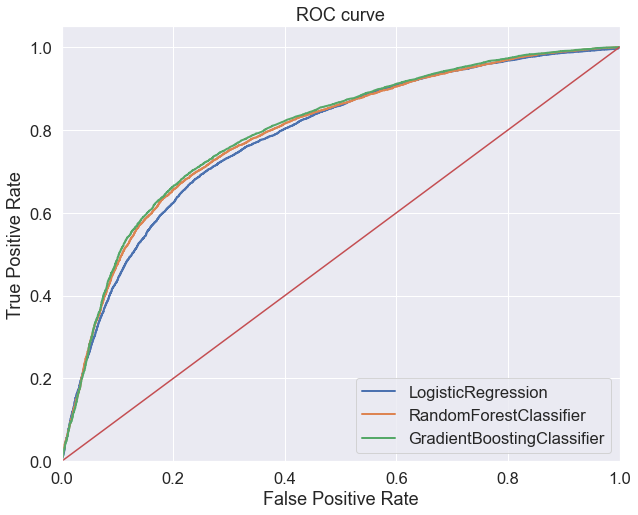

In [70]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr1, tpr1, thresholds_1 = roc_curve(y_test, y_score_lr, pos_label=1)
fpr2, tpr2, thresholds_2 = roc_curve(y_test, y_score_rf, pos_label=1)
fpr3, tpr3, thresholds_3 = roc_curve(y_test, y_score_gb, pos_label=1)
lw = 2

plt.plot(fpr1, tpr1, lw=lw, label='LogisticRegression')
plt.plot(fpr2, tpr2, lw=lw, label='RandomForestClassifier')
plt.plot(fpr3, tpr3, lw=lw, label='GradientBoostingClassifier')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

In [71]:
df1= pd.DataFrame({'metrics': ['thresholds', 'fscore', 'precision', 'recall', 'cv_score'],
                   'LogisticRegression': Logistic_Regression, 'RandomForestClassifier': Random_Forest_Classifier, 'GradientBoostingClassifier': Gradient_Boosting_Classifier})
df1



,metrics,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
0,thresholds,0.389193,0.360568,0.358156
1,fscore,0.728938,0.734252,0.738500
2,precision,0.644507,0.667075,0.678503
3,recall,0.838825,0.816475,0.810138
4,cv_score,0.784437,0.792450,0.797224


Лучший результат показывает модель $GradientBoostingClassifier$

Confusion matrix, without normalization
[[5488 3332]
 [1650 7030]]


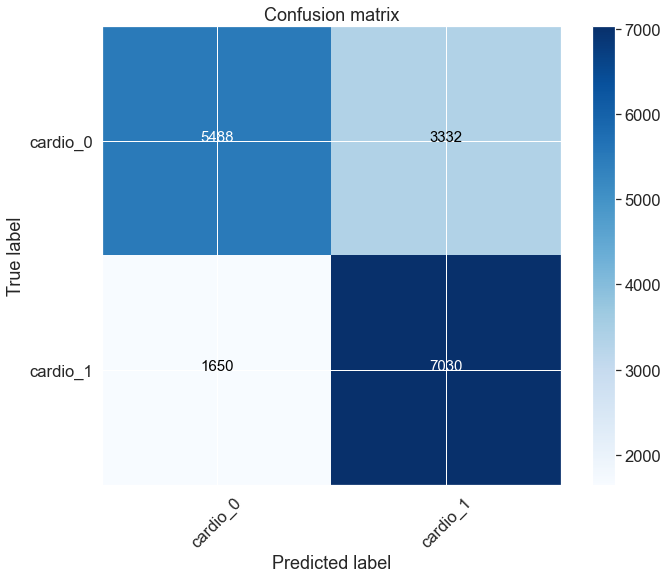

In [74]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 1  # подберем порог для улучшения бизнесс показателя

cnf_matrix = confusion_matrix(y_test, y_score_gb>thresholds_gb[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [75]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR


(0.8099078341013825, 0.37777777777777777, 0.6222222222222222)

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [84]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test_)
    print('расходы, Расходы если использовать ML:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, Расходы если использовать ML: 152581800
 Расходы при решении не делать тесты - расходы с МL : 21018200
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2118200


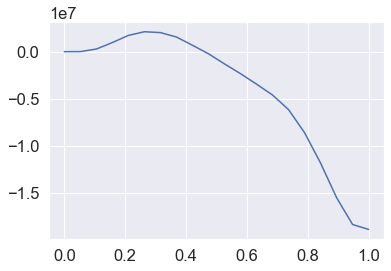

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3581560129533394


In [86]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_gb, 
                                          thresholds_gb[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds_gb[ix])

#### 6. (опциональный вопрос)
какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

- первая помечает 100 объектов как класс 1, но TP = 90\
Confusion matrix

TP &nbsp;90  &nbsp;&nbsp;   FP&nbsp;  10\
FN &nbsp;10  &nbsp;&nbsp;   TN &nbsp; 99890

- вторая помечает 1000 объектов как класс 1, но TP такой же - 90\
Confusion matrix 

TP &nbsp;90  &nbsp;&nbsp;   FP&nbsp;  910\
FN &nbsp;10  &nbsp;&nbsp;   TN &nbsp; 98990

$ROC-AUC$

1 модель

$$TPR = \frac{TP}{TP+FN} = \frac{90}{90+10} = 0,9$$

$$FPR = \frac{FP}{FP+TN} = \frac{10}{10+99890} = 0,0001$$

2 модель

$$TPR = \frac{TP}{TP+FN} = \frac{90}{90+10} = 0,9$$

$$FPR = \frac{FP}{FP+TN} = \frac{910}{910+98990} = 0,009$$

Судя по $FPR$ стоит выбрать 1 модель, т.к. $FPR$ меньше. 

Но разница в $FPR$ между двумя моделями составляет всего 0,0089. 

$ROC-AUC$ измеряет долю $FP$ относительно $TN$ и может показывать не совсем адекватную картину при сильном дисбалансе класссов на разных моделях.

$PR$

1 модель

$$precision = \frac{TP}{TP+FP} = \frac{90}{90+10} = 0.9$$

$$recall = \frac{TP}{TP+FN} = \frac{90}{90+10} = 0.9$$

2 модель

$$precision = \frac{TP}{TP+FP} = \frac{90}{90+910} = 0.09$$

$$recall = \frac{TP}{TP+FN} = \frac{90}{90+10} = 0.9$$

Разница в $precission$ между двумя моделями уже значительно больше и составляет 0,81

Таким образом для сравнения работы моделей пр сильно разбалансированных классах лучше использовать $Precission-Recall$.